![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FMLOps%2FModel+Evaluation&file=model-evaluation-classificaiton-binary.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/MLOps/Model%20Evaluation/model-evaluation-classificaiton-binary.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FMLOps%2FModel%2520Evaluation%2Fmodel-evaluation-classificaiton-binary.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/MLOps/Model%20Evaluation/model-evaluation-classificaiton-binary.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/MLOps/Model%20Evaluation/model-evaluation-classificaiton-binary.ipynb">
      <img width="32px" src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Evaluations For Binary Classification Models

This workflow, part of our [MLOps](../readme.md) series that dives into [Model Evaluation](./readme.md), provides a comprehensive, end-to-end example of building and evaluating a machine learning model directly within Google Cloud's Vertex AI ecosystem.

Specifically, this guide will walk you through how to:

* **Prepare Data at Scale:** Begin by exploring and efficiently preparing a very large public dataset sourced from **BigQuery**, demonstrating how to leverage both powerful **SQL** queries and the interactive **BigFrames API** (pandas interface) for machine learning data readiness.
* **Build Robust Models with Scikit-learn:** Construct a complete **Scikit-learn model pipeline** that seamlessly integrates additional feature engineering steps with the training of a classification model.
* **Register Models in Vertex AI:** Master the crucial MLOps step of saving your trained model and **registering it as a version within the Vertex AI Model Registry** for centralized management and version control.
* **Generate & Upload Custom Metrics:** Delve into preparing **custom, detailed evaluation metrics** using **Scikit-learn**, and then strategically **load these results to your versioned model in the Vertex AI Model Registry**. This includes loading evaluation for each data split including thresholds for the range of prediction cutoffs.
* **Review & Retrieve Evaluations:** Conclude by learning how to easily **review and programmatically retrieve these comprehensive evaluation results** directly from the Model Registry UI and via the **Vertex AI SDK**, empowering you to effectively track and compare model performance over time.

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [2]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [3]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [4]:
# tuples of (import name, install name, min_version)
packages = [
    ('bigframes', 'bigframes'),
    ('sklearn', 'scikit-learn'),
    ('numpy', 'numpy'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'), 
    ('google.cloud.storage', 'google-cloud-storage'),
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('bigquery_magics', 'bigquery-magics'),
    ('matplotlib', 'matplotlib')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

### API Enablement

In [5]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [6]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)
    IPython.display.display(IPython.display.Markdown("""<div class=\"alert alert-block alert-warning\">
        <b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. The previous cells do not need to be run again⚠️</b>
        </div>"""))

---
## Setup

inputs:

In [7]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [8]:
REGION = 'us-central1'
SERIES = 'mlops'
EXPERIMENT = 'evaluation-classification-binary'

# Set the name of GCS Bucket to read/write to
GCS_BUCKET = PROJECT_ID

# Data source for this workflow
BQ_SOURCE = 'bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017'

# make this the BigQuery Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # use a multi region

packages:

In [9]:
import os
import joblib
import sklearn.metrics
import sklearn.ensemble
import sklearn.pipeline
import sklearn.compose
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt

import bigframes.pandas as bpd
from google.cloud import aiplatform
from google.cloud import bigquery
from google.cloud import storage

clients:

In [10]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION, experiment = SERIES+'-'+EXPERIMENT)

# gcs storage client
gcs = storage.Client(project = GCS_BUCKET)
bucket = gcs.bucket(GCS_BUCKET)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# bigframes setup
bpd.options.bigquery.project = PROJECT_ID

# bigquery cell magics load
%load_ext bigquery_magics

Parameters:

In [11]:
DIR = f"files/{EXPERIMENT}"

Environment:

In [12]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## Review Source Data: New York City Yellow Cab Trips (2017)

This is a BigQuery public table containing 113,500,316 individual yellow cab trip records for the year 2017, provided by the New York City Taxi and Limousine Commission (TLC). For our **binary classification** task, we will derive a target variable indicating whether a tip was left or not.

The table includes a rich set of descriptive features, including:

* **`vendor_id`** (string): A code indicating the TPEP provider that provided the record.
* **`pickup_datetime`** (timestamp): The date and time when the meter was engaged.
* **`dropoff_datetime`** (timestamp): The date and time when the meter was disengaged.
* **`passenger_count`** (integer): The number of passengers in the vehicle (driver excluded).
* **`trip_distance`** (float): The elapsed trip distance in miles reported by the taximeter.
* **`fare_amount`** (float): The time-and-distance fare calculated by the meter.
* **`tip_amount`** (float): The amount of tip. This is the basis for our binary target variable.
* **`total_amount`** (float): The total amount charged to the passenger.
* And other columns related to payment type, tolls, etc.

From the **`tip_amount`** column, we will derive our binary target: `has_tip` (1 if `tip_amount > 0`, 0 otherwise).

You can research more about this dataset, including its comprehensive schema and history, at the [NYC Taxi & Limousine Commission website](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) or within the BigQuery public dataset documentation.

Read more about BigQuery public datasets [here](https://cloud.google.com/bigquery/public-data).
 

### Review BigQuery table:

Use the [BigQuery BigFrames](https://cloud.google.com/bigquery/docs/use-bigquery-dataframes) package, setup above, to treat BigQuery tables like dataframes.  This has the advantage of doing the computing within BigQuery rather than pulling the data locally.

In [13]:
source_data = bpd.read_gbq(BQ_SOURCE)
source_data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,airport_fee,total_amount,pickup_location_id,dropoff_location_id,data_file_year,data_file_month
0,1,2017-02-16 19:32:28+00:00,2017-02-16 20:04:21+00:00,1,10.100000000,1,N,1,33.000000000,1.000000000,0.500000000,6.950000000,0E-9,0.300000000,<NA>,41.750000000,138,79,2017,2
1,2,2017-11-09 15:30:47+00:00,2017-11-09 15:41:07+00:00,1,1.170000000,1,N,1,8.000000000,0E-9,0.500000000,1.000000000,0E-9,0.300000000,<NA>,9.800000000,141,162,2017,11
2,1,2017-11-02 08:42:13+00:00,2017-11-02 08:44:18+00:00,1,0.400000000,1,N,1,3.500000000,0E-9,0.500000000,1.050000000,0E-9,0.300000000,<NA>,5.350000000,141,237,2017,11
3,1,2017-09-26 18:49:21+00:00,2017-09-26 19:11:20+00:00,1,3.300000000,1,N,2,16.000000000,1.000000000,0.500000000,0E-9,0E-9,0.300000000,<NA>,17.800000000,48,114,2017,9
4,1,2017-10-08 03:20:00+00:00,2017-10-08 03:21:22+00:00,1,0.300000000,1,N,2,3.000000000,0.500000000,0.500000000,0E-9,0E-9,0.300000000,<NA>,4.300000000,48,48,2017,10


In [14]:
source_data.info()

<class 'bigframes.dataframe.DataFrame'>
Index: 113500316 entries, 0 to 113500315
Data columns (total 20 columns):
  #  Column               Dtype
---  -------------------  ------------------------------
  0  vendor_id            string
  1  pickup_datetime      timestamp[us, tz=UTC][pyarrow]
  2  dropoff_datetime     timestamp[us, tz=UTC][pyarrow]
  3  passenger_count      Int64
  4  trip_distance        decimal128(38, 9)[pyarrow]
  5  rate_code            string
  6  store_and_fwd_flag   string
  7  payment_type         string
  8  fare_amount          decimal128(38, 9)[pyarrow]
  9  extra                decimal128(38, 9)[pyarrow]
 10  mta_tax              decimal128(38, 9)[pyarrow]
 11  tip_amount           decimal128(38, 9)[pyarrow]
 12  tolls_amount         decimal128(38, 9)[pyarrow]
 13  imp_surcharge        decimal128(38, 9)[pyarrow]
 14  airport_fee          decimal128(38, 9)[pyarrow]
 15  total_amount         decimal128(38, 9)[pyarrow]
 16  pickup_location_id   string
 17  drop

In [15]:
source_data.describe(include = 'all')

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store_and_fwd_flag,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,airport_fee,total_amount,pickup_location_id,dropoff_location_id,data_file_year,data_file_month
count,113500316,113500316,113500316,113500316.0,<NA>,113500316,113500316,113500316,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,113500316,113500316,113500316.0,113500316.0
nunique,2,<NA>,<NA>,<NA>,<NA>,7,2,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,265,264,<NA>,<NA>
mean,<NA>,<NA>,<NA>,1.625351,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017.0,6.427337
std,<NA>,<NA>,<NA>,1.265212,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,3.468189
min,<NA>,<NA>,<NA>,0.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017.0,1.0
25%,<NA>,<NA>,<NA>,1.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017.0,3.0
50%,<NA>,<NA>,<NA>,1.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017.0,6.0
75%,<NA>,<NA>,<NA>,2.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017.0,10.0
max,<NA>,<NA>,<NA>,192.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2017.0,12.0


### Understand The Data Source With `ML.DESCRIBE_DATA`

Reviewing a few records, like above, gives a good sense of how the data is arranged. Before proceeding with machine learning techniques it is important to understand more about these raw columns.  Are they ready to use a features in a model or is some form of feature engineering needed first?  For this, the distribution of values is an important starting point.  

While SQL could be used to look at the distribution, it would be a time consuming process and requires different techniques for different data types like numerical, string, boolean, dates, times, array and struct version of these, and arrays of structs.

To make this process fast and simple, the new [`ML.DESCRIBE_DATA`](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-describe-data) function is used to get a single row for each column the describes the data distribution:
- `top_k`: get the top 3 most frequent categories for string columns (default = 1)
- `num_quantiles`: get 4 quantiles for numerical columns (default = 2)

In [16]:
%%bigquery
SELECT *
FROM ML.DESCRIBE_DATA(
    TABLE `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2017`,
    STRUCT(3 as top_k, 4 as num_quantiles)
)

Query is running:   0%|          |

Downloading:   0%|          |

,name,num_rows,num_nulls,num_zeros,min,max,mean,stddev,median,quantiles,unique,avg_string_length,num_values,top_values,min_array_length,max_array_length,avg_array_length,total_array_length,array_length_quantiles,dimension
0,airport_fee,113500316,113500316,0,None,None,NaN,NaN,NaN,[],<NA>,NaN,0,[],<NA>,<NA>,NaN,<NA>,[],<NA>
1,data_file_month,113500316,0,0,1,12,6.427337,3.468189,6.00,"[1.0, 3.0, 6.0, 10.0, 12.0]",<NA>,NaN,113500316,[],<NA>,<NA>,NaN,<NA>,[],<NA>
2,data_file_year,113500316,0,0,2017,2017,2017.000000,0.000000,2017.00,"[2017.0, 2017.0, 2017.0, 2017.0, 2017.0]",<NA>,NaN,113500316,[],<NA>,<NA>,NaN,<NA>,[],<NA>
3,dropoff_datetime,113500316,0,<NA>,1997-07-22 15:30:46+00,2053-03-21 16:52:21+00,NaN,NaN,NaN,[],28055922,22.000000,113500316,"[{'value': '2017-09-14 20:31:49+00', 'count': ...",<NA>,<NA>,NaN,<NA>,[],<NA>
4,dropoff_location_id,113500316,0,<NA>,1,99,NaN,NaN,NaN,[],264,2.772419,113500316,"[{'value': '161', 'count': 4197990}, {'value':...",<NA>,<NA>,NaN,<NA>,[],<NA>
5,extra,113500316,0,59634752,-58.64,14000,0.331238,1.391081,0.00,"[-58.64, 0.0, 0.0, 0.5, 14000.0]",<NA>,NaN,113500316,[],<NA>,<NA>,NaN,<NA>,[],<NA>
6,fare_amount,113500316,0,33903,-550,861604.49,13.047940,190.357505,9.50,"[-550.0, 6.5, 9.5, 14.5, 861604.49]",<NA>,NaN,113500316,[],<NA>,<NA>,NaN,<NA>,[],<NA>
7,imp_surcharge,113500316,0,32146,-0.3,1,0.299621,0.014309,0.30,"[-0.3, 0.3, 0.3, 0.3, 1.0]",<NA>,NaN,113500316,[],<NA>,<NA>,NaN,<NA>,[],<NA>
8,mta_tax,113500316,0,517733,-0.5,250,0.497292,0.069059,0.50,"[-0.5, 0.5, 0.5, 0.5, 250.0]",<NA>,NaN,113500316,[],<NA>,<NA>,NaN,<NA>,[],<NA>
9,passenger_count,113500316,0,166087,0,192,1.625351,1.265212,1.00,"[0.0, 1.0, 1.0, 2.0, 192.0]",<NA>,NaN,113500316,[],<NA>,<NA>,NaN,<NA>,[],<NA>


---
## Prepare Data Source

The data preparation includes adding splits for machine learning with a column named `splits` with values for training (`TRAIN`), validation (`VALIDATE`), and for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `trip_id`. 

>These steps could be done locally at training but are instead done in the source system, BigQuery in this case, which provides several advantages:
>
>-   **Single Source of Truth:** A single data preparation can benefit multiple model training jobs for different architectures or even different team members working on the same model. This ensures consistency and avoids duplication of effort.
>-   **Leverage BigQuery's Power:** BigQuery is highly optimized for large-scale data processing. Performing these operations directly in BigQuery leverages its distributed processing capabilities, making the preparation significantly faster and more efficient than local processing, especially for massive datasets.
>-   **Reduced Data Movement:** Preparing the data in BigQuery reduces the amount of data that needs to be moved out of BigQuery and into the training environment. This minimizes latency and potential bottlenecks associated with data transfer.
>-   **Data Versioning and Reproducibility:** By preparing the splits and unique ID in BigQuery, the specific dataset used for training can be easily tracked and versioned. This enhances the reproducibility of experiments and makes it easier to understand the provenance of the data used in a particular model.
>-   **Simplified Training Pipeline:** The training pipeline becomes simpler because it can directly read pre-split data from BigQuery, eliminating the need for complex splitting logic within the training code.
>-   **Pre-calculated Joins and Features:** BigQuery can be used to pre-calculate joins and engineer new features that are beneficial for the model. This can improve model performance and further reduce the workload during the training phase.
>
>**Further Considerations:**
>
>-   **Data Governance and Security:** BigQuery offers robust data governance and security features. Performing data preparation within BigQuery allows you to maintain control over access and ensure data quality.
>-   **Scalability:** This approach is highly scalable. As your dataset grows, BigQuery can handle the increased workload without requiring significant changes to your data preparation pipeline.
>-   **Cost Optimization:** While moving large amounts of data out of BigQuery can incur costs, performing the preparation steps within BigQuery and only extracting the necessary data for training can often be more cost-effective.
>
>By preparing the data in BigQuery, you create a streamlined, efficient, and reproducible workflow (pipeline) that leverages the strengths of the platform and sets your machine learning models up for success.


### Create/Recall Dataset

In [17]:
dataset = bigquery.Dataset(f"{BQ_PROJECT}.{BQ_DATASET}")
dataset.location = BQ_REGION
bq_dataset = bq.create_dataset(dataset, exists_ok = True)

### Create/Recall Table With Preparation For ML

Copy the data from the source while adding columns:
- `trip_id` as a unique identify for the row
    - Use the `GENERATE_UUID()` function
- `splits` column to randomly assign rows to 'TRAIN", "VALIDATE" and "TEST" groups
    - stratified sampling within the levels of `class` by first assigning row numbers within the levels of `class` then using the with a CASE statment to assign the `splits` level.

In [18]:
job = bq.query(f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}` AS
WITH
    base_data AS (
        SELECT
            -- Categorical features (ensure string casting if not already)
            vendor_id, -- Already string
            rate_code, -- Already string
            payment_type, -- Already string
            store_and_fwd_flag, -- Already string
            pickup_location_id, -- Already string
            dropoff_location_id, -- Already string
            CASE WHEN airport_fee > 0 THEN 1 ELSE 0 END AS has_airport_fee, -- create categorical variable for airport_fee
            
            -- Numerical features
            passenger_count,
            trip_distance,
            fare_amount,
            extra,
            mta_tax,
            tip_amount, -- Used for target, but also useful as a feature for other tasks
            tolls_amount,
            imp_surcharge,
            total_amount,

            -- Derived features
            TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) AS trip_duration_seconds,
            
            -- Raw timestamps for potential future BigFrames datetime operations or direct use
            pickup_datetime,
            dropoff_datetime,

            -- Create the binary target: has_tip
            CASE WHEN tip_amount > 0 THEN 1 ELSE 0 END AS has_tip,
            -- Add an ID and row number for stratified splitting
            GENERATE_UUID() AS trip_id,
            ROW_NUMBER() OVER (PARTITION BY (CASE WHEN tip_amount > 0 THEN 1 ELSE 0 END) ORDER BY RAND()) as rn
        FROM `{BQ_SOURCE}`
        WHERE
            -- Basic filtering for valid trips: positive duration, passengers, and non-zero fare/tip amounts
            TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) > 0 AND
            passenger_count > 0 AND
            fare_amount > 0 AND
            tip_amount IS NOT NULL -- Exclude trips where tip_amount is unknown
            AND pickup_datetime BETWEEN '2017-01-01 00:00:00' AND '2017-12-31 23:59:59' -- Filter for 2017 data only
            -- You might add more filtering for outliers like extremely long distances, or invalid coordinates if available

    )
SELECT
    * EXCEPT(rn),
    CASE -- 10% for train, 1% for validation, 1% for test
        WHEN rn <= 0.0015 * COUNT(*) OVER (PARTITION BY has_tip) THEN 'TRAIN'
        WHEN rn <= 0.0016 * COUNT(*) OVER (PARTITION BY has_tip) THEN 'VALIDATE'
        WHEN rn <= 0.0017 * COUNT(*) OVER (PARTITION BY has_tip) THEN 'TEST'
        ELSE Null -- records not samples for using in training here
    END AS splits
FROM
    base_data
""")
job.result()
(job.ended-job.started).total_seconds()

29.388

In [19]:
source_data_prepared = bpd.read_gbq(f"{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}", use_cache = False)
source_data_prepared.head()

,vendor_id,rate_code,payment_type,store_and_fwd_flag,pickup_location_id,dropoff_location_id,has_airport_fee,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,imp_surcharge,total_amount,trip_duration_seconds,pickup_datetime,dropoff_datetime,has_tip,trip_id,splits
0,2,1,1,N,234,137,0,1,1.420000000,7.000000000,...,1.080000000,0E-9,0.300000000,9.380000000,440,2017-06-14 22:47:27+00:00,2017-06-14 22:54:47+00:00,1,e11231f7-33c3-484b-a6eb-0829261cdb4a,<NA>
1,1,1,1,N,233,164,0,1,1.400000000,9.000000000,...,2.700000000,0E-9,0.300000000,13.500000000,693,2017-04-24 18:51:58+00:00,2017-04-24 19:03:31+00:00,1,18d77462-c348-4dd9-bfc6-0d06018b56d6,<NA>
2,2,1,1,N,261,125,0,1,1.490000000,7.000000000,...,1.560000000,0E-9,0.300000000,9.360000000,447,2017-05-29 13:46:53+00:00,2017-05-29 13:54:20+00:00,1,fb30f443-1526-41b7-bb77-15cc458f3931,<NA>
3,2,1,1,N,142,263,0,2,2.060000000,13.500000000,...,3.200000000,0E-9,0.300000000,18.500000000,1219,2017-03-16 19:17:57+00:00,2017-03-16 19:38:16+00:00,1,49e4f341-854b-48b0-844f-4a382ab5dfad,<NA>
4,1,1,2,N,231,45,0,1,2.100000000,15.500000000,...,0E-9,0E-9,0.300000000,16.300000000,1487,2017-01-29 13:35:30+00:00,2017-01-29 14:00:17+00:00,0,6904e231-556b-4362-b83e-dfcbfffe9b62,<NA>


### Review the number of records for each level of `has_tip` for each of the data splits:

In [20]:
bq.query(f"""
SELECT splits, has_tip,
    count(*) as count,
    ROUND(count(*) * 100.0 / SUM(count(*)) OVER (PARTITION BY has_tip), 2) AS percentage
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
GROUP BY splits, has_tip
ORDER BY has_tip, splits
""").to_dataframe()

,splits,has_tip,count,percentage
0,None,0,40183646,99.83
1,TEST,0,4025,0.01
2,TRAIN,0,60378,0.15
3,VALIDATE,0,4025,0.01
4,None,1,72768354,99.83
5,TEST,1,7289,0.01
6,TRAIN,1,109338,0.15
7,VALIDATE,1,7289,0.01


### Further Data Preparation



#### Rows Assigned To A Split (TRAIN, TEST, VALIDATE)

Avoid the unsampled rows where `splits = Null`:

In [21]:
# only use rows assigned to a split:
source_data_prepared_filtered = source_data_prepared[source_data_prepared['splits'].notna()]

#### Group Columns By Type

In [22]:
# Numerical columns
numerical_cols = [
    'trip_duration_seconds',
    'passenger_count',
    'trip_distance',
    'fare_amount',
    'extra',
    'mta_tax',
    'tolls_amount',
    'imp_surcharge',
    'total_amount'
]

# Categorical columns
categorical_cols = [
    'vendor_id',
    'rate_code',
    'payment_type',
    'store_and_fwd_flag',
    'pickup_location_id',
    'dropoff_location_id',
    'has_airport_fee'
]

target_col = 'has_tip'
split_col = 'splits'
id_col = 'trip_id' # Keep id for later lookup if needed, but not as a feature
datetime_cols = ['pickup_datetime', 'dropoff_datetime'] # Keep these if you want to derive more features in BigFrames


#### Check For Columns With NaNs

In [23]:
source_data_prepared_filtered[numerical_cols + categorical_cols + [target_col]].isna().sum()

trip_duration_seconds    0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tolls_amount             0
imp_surcharge            0
total_amount             0
vendor_id                0
rate_code                0
payment_type             0
store_and_fwd_flag       0
pickup_location_id       0
dropoff_location_id      0
has_airport_fee          0
has_tip                  0
dtype: Int64

#### Setup Pointers For Training

In [24]:
X_frame = source_data_prepared_filtered[numerical_cols + categorical_cols]
y_frame = source_data_prepared_filtered[target_col]
splits_frame = source_data_prepared_filtered[split_col]

print(f"There are {X_frame.shape[0]} training rows for {X_frame.shape[1]} raw features.")
print(f"Confirming the rows for splits and the label are {splits_frame.shape[0]} and {y_frame.shape[0]} respectively.")

There are 192344 training rows for 16 raw features.
Confirming the rows for splits and the label are 192344 and 192344 respectively.


---
## Train With Scikit-Learn

### Local Dataframes

Convert the Bigframes pointers to Pandas dataframes for the training objects:

In [25]:
X_train = X_frame[splits_frame == 'TRAIN'].to_pandas()
X_val = X_frame[splits_frame == 'VALIDATE'].to_pandas()
X_test = X_frame[splits_frame == 'TEST'].to_pandas()

y_train = y_frame[splits_frame == 'TRAIN'].to_pandas()
y_val = y_frame[splits_frame == 'VALIDATE'].to_pandas()
y_test = y_frame[splits_frame == 'TEST'].to_pandas()

In [26]:
X_train.shape, y_train.shape

((169716, 16), (169716,))

### Define A Preprocessor

Create a Scikit-Learn preprocessor that standardizes numeric variables and one-hot encodes categorical variables:

In [27]:
preprocessor = sklearn.compose.ColumnTransformer(
    transformers = [
        # Apply StandardScaler to numerical columns
        ('num', sklearn.preprocessing.StandardScaler(), numerical_cols),
        # Apply OneHotEncoder to categorical columns
        ('cat', sklearn.preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse_output = False), categorical_cols)
    ],
    remainder = 'passthrough' # Keep any other columns not explicitly listed (if any) as they are
)

### Define A Model Pipeline: Proprocessor + Model

Combine the preprocessor with the model type in a pipeline:

In [28]:
model_pipeline = sklearn.pipeline.Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('classifier', sklearn.ensemble.GradientBoostingClassifier(
            n_estimators=100,    # You can tune this
            learning_rate=0.1,   # You can tune this
            max_depth=3,         # Crucial for size and speed with GBTs
            random_state=42      # For reproducibility
        ))
    ]
)

### Train/Fit The Model

Use the training data to train the model using the pipeline:

In [29]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['trip_duration_seconds',
                                                   'passenger_count',
                                                   'trip_distance',
                                                   'fare_amount', 'extra',
                                                   'mta_tax', 'tolls_amount',
                                                   'imp_surcharge',
                                                   'total_amount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['vendor_id', 'rate_code',
                                                   'payment_type',
                                                   'store_and_fwd_flag',
                                                   'pickup_location_id',
                                                   'dropoff_location_id',
                                                   'has_airport_fee'])])),
                ('classifier', GradientBoostingClassifier(random_state=42))])

---
## Evaluate The Model

Use the [Scikit-Learn metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html) module to get evaluation metrics for the model on the data splits.

In [31]:
y_pred_class_test = model_pipeline.predict(X_test)
y_pred_proba_test = model_pipeline.predict_proba(X_test)[:, 1]

In [33]:
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_pred_class_test)
print(f"Accuracy (TEST): {test_accuracy:.4f}")

test_prc_auc = sklearn.metrics.average_precision_score(y_test, y_pred_proba_test)
print(f"PRC AUC (TEST): {test_prc_auc:.4f}")

test_roc_auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba_test)
print(f"ROC AUC (TEST): {test_roc_auc:.4f}")

test_log_loss = sklearn.metrics.log_loss(y_test, y_pred_proba_test)
print(f"Log Loss (TEST): {test_log_loss:.4f}")

Accuracy (TEST): 0.9784
PRC AUC (TEST): 0.9992
ROC AUC (TEST): 0.9987
Log Loss (TEST): 0.0593


In [34]:
print("\nClassification Report (TEST Split):")
print(sklearn.metrics.classification_report(y_test, y_pred_class_test))


Classification Report (TEST Split):
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      4025
         1.0       0.97      1.00      0.98      7289

    accuracy                           0.98     11314
   macro avg       0.98      0.97      0.98     11314
weighted avg       0.98      0.98      0.98     11314



In [35]:
print("\nConfusion Matrix (TEST Split):")
print(sklearn.metrics.confusion_matrix(y_test, y_pred_class_test))


Confusion Matrix (TEST Split):
[[3782  243]
 [   1 7288]]


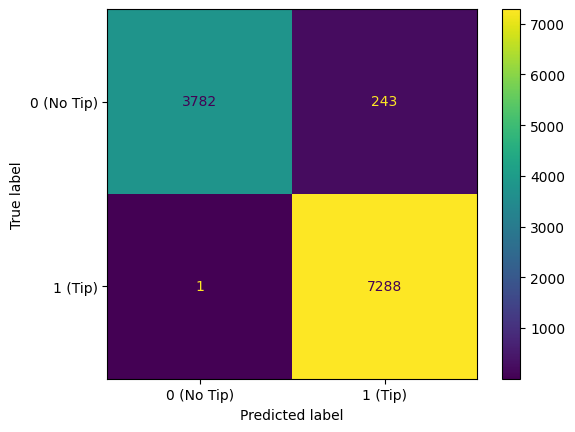

In [36]:
disp = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_class_test),
    display_labels=['0 (No Tip)', '1 (Tip)']
)
disp.plot()

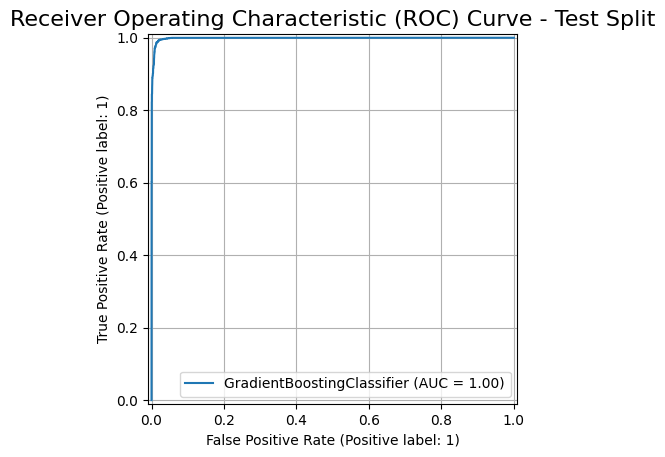

In [39]:
roc_display = sklearn.metrics.RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_proba_test,
    name = 'GradientBoostingClassifier'
)
#roc_display.plot()
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Split', fontsize=16)
plt.grid(True) # Add a grid for better readability
plt.show() # Display the plot

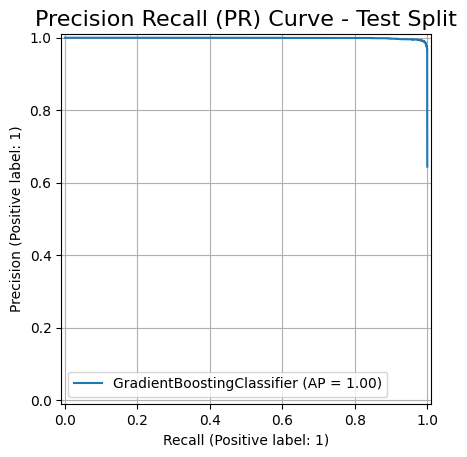

In [40]:
pr_display = sklearn.metrics.PrecisionRecallDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_proba_test,
    name = 'GradientBoostingClassifier'
)
#pr_display.plot()
plt.title('Precision Recall (PR) Curve - Test Split', fontsize=16)
plt.grid(True) # Add a grid for better readability
plt.show() # Display the plot

### Explanations: Feature Importance

Get the names of the feature from the transformation part of the pipeline:

In [44]:
transformed_features_names = model_pipeline.named_steps['preprocessor'].get_feature_names_out()

Get the feature importance calcualtion from the model part of the pipeline:

In [45]:
importances = model_pipeline.named_steps['classifier'].feature_importances_

Create a dictionary that maps the transformed feature names to their importance:

In [46]:
feature_importances_map = dict(zip(transformed_features_names, importances))

Aggregate the features importance for the categorical features that have been expanded with One-Hot encoding:

In [47]:
original_feature_importances = {}

# Add numerical features directly
for col in numerical_cols:
    if f'num__{col}' in feature_importances_map: # ColumnTransformer prefixes names
        original_feature_importances[col] = feature_importances_map[f'num__{col}']

# Aggregate for categorical features
for original_cat_col in categorical_cols:
    sum_importance = 0
    # Iterate through the transformed feature names
    for transformed_feature_name, importance_value in feature_importances_map.items():
        # Check if the transformed feature name starts with the prefix for this original categorical column
        if transformed_feature_name.startswith(f'cat__{original_cat_col}_'):
            sum_importance += importance_value
    original_feature_importances[original_cat_col] = sum_importance

Review the feature importance for the original features:

In [48]:
sorted_importances = sorted(original_feature_importances.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: payment_type, Importance: 0.9688
Feature: fare_amount, Importance: 0.0198
Feature: total_amount, Importance: 0.0095
Feature: rate_code, Importance: 0.0009
Feature: vendor_id, Importance: 0.0004
Feature: extra, Importance: 0.0003
Feature: trip_duration_seconds, Importance: 0.0001
Feature: dropoff_location_id, Importance: 0.0001
Feature: pickup_location_id, Importance: 0.0001
Feature: trip_distance, Importance: 0.0000
Feature: tolls_amount, Importance: 0.0000
Feature: passenger_count, Importance: 0.0000
Feature: mta_tax, Importance: 0.0000
Feature: imp_surcharge, Importance: 0.0000
Feature: store_and_fwd_flag, Importance: 0.0000
Feature: has_airport_fee, Importance: 0.0000


---
## Register The Model In Vertex AI Model Registry

### Save The Model

Use the [joblib](https://joblib.readthedocs.io/en/stable/) to save the model pipeline to a local folder.

In [51]:
model_filename = os.path.join(DIR, 'model.joblib')

try:
    joblib.dump(model_pipeline, model_filename)
    print(f"Model pipeline saved successfully to: {model_filename}")
except Exception as e:
    print(f"Error saving model pipeline: {e}")

Model pipeline saved successfully to: files/evaluation-classification-binary/model.joblib


### Move The Model To GCS

Store the joblib file in GCS for use with the Vertex AI Model Registry.

In [52]:
blob_path = f"{SERIES}/{EXPERIMENT}/model_files"
blob_name = os.path.basename(model_filename)
blob = bucket.blob(os.path.join(blob_path, blob_name))

try:
    blob.upload_from_filename(model_filename, timeout = 600) 
    print(f"Model pipeline uploaded successfully to GCS: gs://{bucket.name}/{blob.name}")
except Exception as e:
    print(f"Error uploading model pipeline to GCS: {e}")

Model pipeline uploaded successfully to GCS: gs://statmike-mlops-349915/mlops/evaluation-classification-binary/model_files/model.joblib


### Register The Model

Registering the model in the [Vertex AI Model Registry](https://cloud.google.com/vertex-ai/docs/model-registry/introduction) requires:
- A GCS URI for the model files
- A Artifact Registry URI to a container than can serve the model files

Vertex AI includes prebuilt containers for [training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers) and [serving](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers) including [these](https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers#scikit-learn) that are purpose built for Scikit-Learn.  You can alos customize these containers (or your own container) as a [custom prediction container](https://cloud.google.com/vertex-ai/docs/predictions/use-custom-container).  For an example check out this workflow in this repository: [Catboost Custom Prediction With FastAPI](../../Framework%20Workflows/CatBoost/CatBoost%20Custom%20Prediction%20With%20FastAPI.ipynb).

Check for existing version of the model:

In [53]:
parent_model = next(
    (model for model in aiplatform.Model.list(filter=f'display_name="{SERIES}-{EXPERIMENT}"')),
    None # Default value if no model/version is found
)
parent_model

Upload the model to the registry as a new version which will be version 1 if no prior version was found:

In [54]:
vertex_model = aiplatform.Model.upload(
    display_name = SERIES+'-'+EXPERIMENT,
    model_id = SERIES+'-'+EXPERIMENT,
    parent_model = parent_model,
    serving_container_image_uri = 'us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-5:latest',
    artifact_uri = f'gs://{bucket.name}/{blob_path}',
    is_default_version = True,
    labels = {'series': SERIES, 'experiment': EXPERIMENT}
)

Creating Model
Create Model backing LRO: projects/1026793852137/locations/us-central1/models/mlops-evaluation-classification-binary/operations/5088211437327745024
Model created. Resource name: projects/1026793852137/locations/us-central1/models/mlops-evaluation-classification-binary@1
To use this Model in another session:
model = aiplatform.Model('projects/1026793852137/locations/us-central1/models/mlops-evaluation-classification-binary@1')


---
## Load Model Evaluations To The Vertex AI Model Registry

The versioned models in Vertex AI Model Registry can include evaluations.  Evaluation can even be vizualized and compared directly in the console.  

The model registry, and Vertex AI SDK, include model evaluations as a service where managed jobs can be used to calculate predictions and automatically laod evaluation metrics based on the model type (regression, classification, or forecasting). Read more about [Model evaluation in Vertex AI](https://cloud.google.com/vertex-ai/docs/evaluation/introduction).

In this workflow the evaluation will be manually uploaded with the Vertex AI SDK after first being prepared locally.  The evaluation need to be prepared in the format of one of the schems provided [here](https://console.cloud.google.com/storage/browser/google-cloud-aiplatform/schema/modelevaluation).

This part of the workflow will demonstrate preparing the full set of evaluation metrics for the model above on each split of the data and then loading in the versioned model in the model registry.  The evaluation will then be shown in the console, and retrieved with the SDK.


### Structured Evaluation

First, prepare the evaluations for the model in the structure of the provided schema `google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml` found in the GCS location that is publically available here: [google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml](https://console.cloud.google.com/storage/browser/google-cloud-aiplatform/schema/modelevaluation).

In this example the complete schema is used but it is possible to provide a limited subset.

In [62]:
evaluations = {}
explanations = {}

data_splits = {
    'TRAIN': (X_train, y_train),
    'VALIDATE': (X_val, y_val),
    'TEST': (X_test, y_test)
}

In [63]:
for split_name, (X_split, y_split) in data_splits.items():
    # predictions
    y_pred_proba = model_pipeline.predict_proba(X_split)[:, 1]
    y_pred_class_default_threshold = (y_pred_proba >= 0.5).astype(int)
    # overall metrics
    au_prc_val = sklearn.metrics.average_precision_score(y_split, y_pred_proba)
    au_roc_val = sklearn.metrics.roc_auc_score(y_split, y_pred_proba)
    log_loss_val = sklearn.metrics.log_loss(y_split, y_pred_proba)
    overall_conf_matrix = sklearn.metrics.confusion_matrix(y_split, y_pred_class_default_threshold, labels=[0, 1])
    # confidence metrics for splits
    confidence_thresholds = (
        list(np.arange(0.0, 1.0, 0.05)) + # 0.00, 0.05, ..., 0.95
        list(np.arange(0.95, 1.0, 0.01))  # 0.95, 0.96, ..., 0.99
    )
    confidence_thresholds = sorted(list(set([round(t, 2) for t in confidence_thresholds])))
    confidence_metrics_list = []
    for threshold in confidence_thresholds:
        y_pred_at_threshold = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_split, y_pred_at_threshold, labels=[0, 1]).ravel()
        recall_val = sklearn.metrics.recall_score(y_split, y_pred_at_threshold, zero_division=0)
        precision_val = sklearn.metrics.precision_score(y_split, y_pred_at_threshold, zero_division=0)
        false_positive_rate_val = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        f1_score_val = sklearn.metrics.f1_score(y_split, y_pred_at_threshold, zero_division=0)
        confidence_metrics_entry = {
            'confidenceThreshold': threshold,
            #'maxPredictions': 2147483647, # As per schema
            'recall': recall_val,
            'precision': precision_val,
            'falsePositiveRate': false_positive_rate_val,
            'f1Score': f1_score_val,
            # f1ScoreMicro and f1ScoreMacro are typically for multi-class/multi-label, omitted for binary simplicity
            # recallAt1, precisionAt1, etc. are for top-k predictions, typically not applicable for standard binary thresholding
            'truePositiveCount': int(tp),
            'falsePositiveCount': int(fp),
            'falseNegativeCount': int(fn),
            'trueNegativeCount': int(tn),
            'confusionMatrix': { # Optional confusion matrix for each threshold
                'annotationSpecs': [{'id': '0', 'displayName': '0 (No Tip)'}, {'id' : '1', 'displayName': '1 (Tip)'}], # Assuming class labels are 0 and 1
                'rows': [{'dataItemCounts': sklearn.metrics.confusion_matrix(y_split, y_pred_at_threshold, labels=[0, 1])[0].tolist()},
                         {'dataItemCounts': sklearn.metrics.confusion_matrix(y_split, y_pred_at_threshold, labels=[0, 1])[1].tolist()}]
            }
        }
        confidence_metrics_list.append(confidence_metrics_entry)
    evaluations[split_name] = {
        'auPrc': au_prc_val,
        'auRoc': au_roc_val,
        'logLoss': log_loss_val,
        'confidenceMetrics': confidence_metrics_list,
        'confusionMatrix': { # Overall confusion matrix at default 0.5 threshold
            'annotationSpecs': [{'id': '0', 'displayName': '0 (No Tip)'}, {'id' : '1', 'displayName': '1 (Tip)'}],
            'rows': [{'dataItemCounts': overall_conf_matrix[0].tolist()},
                     {'dataItemCounts': overall_conf_matrix[1].tolist()}]
        }
    }

In [73]:
for split_name, (X_split, y_split) in data_splits.items():

    original_feature_importances = {}

    # Add numerical features directly
    for col in numerical_cols:
        if f'num__{col}' in feature_importances_map: # ColumnTransformer prefixes names
            original_feature_importances[col] = feature_importances_map[f'num__{col}']

    # Aggregate for categorical features
    for original_cat_col in categorical_cols:
        sum_importance = 0
        # Iterate through the transformed feature names
        for transformed_feature_name, importance_value in feature_importances_map.items():
            # Check if the transformed feature name starts with the prefix for this original categorical column
            if transformed_feature_name.startswith(f'cat__{original_cat_col}_'):
                sum_importance += importance_value
        original_feature_importances[original_cat_col] = sum_importance

    explanations[split_name] = {
        'mean_attributions': [
            {
                'feature_attributions': original_feature_importances
            }
        ]
    }

Review the metrics for the first threshold of the 'TRAIN' split:

In [74]:
evaluations['TRAIN']['confidenceMetrics'][0]

{'confidenceThreshold': np.float64(0.0),
 'recall': 1.0,
 'precision': 0.644240967262957,
 'falsePositiveRate': np.float64(1.0),
 'f1Score': 0.7836332752800533,
 'truePositiveCount': 109338,
 'falsePositiveCount': 60378,
 'falseNegativeCount': 0,
 'trueNegativeCount': 0,
 'confusionMatrix': {'annotationSpecs': [{'id': '0',
    'displayName': '0 (No Tip)'},
   {'id': '1', 'displayName': '1 (Tip)'}],
  'rows': [{'dataItemCounts': [0, 60378]}, {'dataItemCounts': [0, 109338]}]}}

In [75]:
explanations['TRAIN']

{'mean_attributions': [{'feature_attributions': {'trip_duration_seconds': np.float64(0.00011854211465183962),
    'passenger_count': np.float64(0.0),
    'trip_distance': np.float64(2.405477292685259e-05),
    'fare_amount': np.float64(0.01980275008780098),
    'extra': np.float64(0.0002808354773972286),
    'mta_tax': np.float64(0.0),
    'tolls_amount': np.float64(1.3634696928595712e-05),
    'imp_surcharge': np.float64(0.0),
    'total_amount': np.float64(0.009544035900701901),
    'vendor_id': np.float64(0.00042666229864359495),
    'rate_code': np.float64(0.0008573892672347172),
    'payment_type': np.float64(0.9687784944595148),
    'store_and_fwd_flag': np.float64(0.0),
    'pickup_location_id': np.float64(6.947928271744367e-05),
    'dropoff_location_id': np.float64(8.412164148185023e-05),
    'has_airport_fee': np.float64(0.0)}}]}

### Load The Evaluations

Use the [ModelServiceClient](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.model_service) to load the evaluation metrics with the [import_model_evaluation](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.model_service.ModelServiceClient#google_cloud_aiplatform_v1_services_model_service_ModelServiceClient_import_model_evaluation) method.

In [76]:
model_client = aiplatform.gapic.ModelServiceClient(
    client_options = {'api_endpoint': f"{REGION}-aiplatform.googleapis.com"}
)

In [77]:
for eval in evaluations:
    eval_upload = model_client.import_model_evaluation(
        parent = vertex_model.versioned_resource_name,
        model_evaluation = aiplatform.gapic.ModelEvaluation(
            display_name = f'training-{eval.lower()}',
            metrics_schema_uri = 'gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml',
            metrics = evaluations[eval],
            model_explanation = explanations[eval]
        )
    )

### Review Evaluation In The Vertex AI Console

'<div style="text-align: center;"><img src="../resources/images/screenshots/evaluation/class-binary/registry_evaluations.png" style="border: 2px solid black; width: auto; height: 600px;"></div>

'<div style="text-align: center;"><img src="../resources/images/screenshots/evaluation/class-binary/registry_evaluation_review.gif" style="border: 2px solid black; width: auto; height: 600px;"></div>

In [142]:
print(f"Direct Link:\nhttps://console.cloud.google.com/vertex-ai/models/locations/{REGION}/models/{vertex_model.name}/versions/{vertex_model.version_id}/evaluations")

Direct Link:
https://console.cloud.google.com/vertex-ai/models/locations/us-central1/models/mlops-evaluation-classification-binary/versions/1/evaluations


### Retrieve The Model Evaluations: Vertex AI SDK

Use the same model object we created above to laod the model to the registry to also retrieve the evaluations.
- [Model.list_model_evaluations](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_list_model_evaluations)

In [143]:
vertex_eval_list = vertex_model.list_model_evaluations()
[e.display_name for e in vertex_eval_list]

['training-validate', 'training-train', 'training-test']

In [144]:
dict(vertex_eval_list[0].metrics)

{'auPrc': 0.9990411,
 'auRoc': 0.99859875,
 'logLoss': 0.057955153,
 'confusionMatrix': <proto.marshal.collections.maps.MapComposite at 0x7fbc45084fe0>,
 'confidenceMetrics': [<proto.marshal.collections.maps.MapComposite object at 0x7fbc45084bf0>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45085f10>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45086480>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc450879e0>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45084d70>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45087890>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45085280>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc450868d0>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45084c80>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45084fb0>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45085040>, <proto.marshal.collections.maps.

In [145]:
dict(vertex_eval_list[0].metrics['confusionMatrix'])

{'rows': [[37982.0, 2270.0], [6.0, 72886.0]],
 'annotationSpecs': [<proto.marshal.collections.maps.MapComposite object at 0x7fbc45086960>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45087b30>]}

In [146]:
type(vertex_eval_list[0])

google.cloud.aiplatform.model_evaluation.model_evaluation.ModelEvaluation

In [147]:
vertex_eval_list[0].to_dict()

{'name': 'projects/1026793852137/locations/us-central1/models/mlops-evaluation-classification-binary@1/evaluations/3215180941155188366',
 'metricsSchemaUri': 'gs://google-cloud-aiplatform/schema/modelevaluation/classification_metrics_1.0.0.yaml',
 'metrics': {'auPrc': 0.9990411,
  'auRoc': 0.99859875,
  'logLoss': 0.057955153,
  'confusionMatrix': {'rows': [[37982.0, 2270.0], [6.0, 72886.0]],
   'annotationSpecs': [{'displayName': '0 (No Tip)', 'id': '0'},
    {'displayName': '1 (Tip)', 'id': '1'}]},
  'confidenceMetrics': [{'precision': 0.644241,
    'falseNegativeCount': '0',
    'truePositiveCount': '72892',
    'recall': 1.0,
    'trueNegativeCount': '0',
    'confidenceThreshold': 0.0,
    'falsePositiveRate': 1.0,
    'falsePositiveCount': '40252',
    'confusionMatrix': {'rows': [[0.0, 40252.0], [0.0, 72892.0]],
     'annotationSpecs': [{'displayName': '0 (No Tip)', 'id': '0'},
      {'displayName': '1 (Tip)', 'id': '1'}]},
    'f1Score': 0.7836333},
   {'precision': 0.95744234,

### Retrieve The Model Evaluations: Vertex AI SDK ModelServiceClient

Use the [ModelServiceClient](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.model_service) to retreive the evaluation metrics with the [list_model_evaluations](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform_v1.services.model_service.ModelServiceClient#google_cloud_aiplatform_v1_services_model_service_ModelServiceClient_list_model_evaluations) method.

In [148]:
vertex_eval_list = iter(model_client.list_model_evaluations(parent = vertex_model.versioned_resource_name))

In [149]:
eval = next(vertex_eval_list)

In [150]:
dict(eval.metrics)

{'auPrc': 0.9990411,
 'auRoc': 0.99859875,
 'logLoss': 0.057955153,
 'confusionMatrix': <proto.marshal.collections.maps.MapComposite at 0x7fbc45084e30>,
 'confidenceMetrics': [<proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2c4a0>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2d1c0>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2c170>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2d5b0>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2c440>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2cd40>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2e240>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2e8d0>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2fb30>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2fa40>, <proto.marshal.collections.maps.MapComposite object at 0x7fbc45d2dee0>, <proto.marshal.collections.maps.

In [152]:
type(eval)

google.cloud.aiplatform_v1.types.model_evaluation.ModelEvaluation

---
## More Ways To Work With Evaluations

The [Vertex AI Experiment service](https://cloud.google.com/vertex-ai/docs/experiments/intro-vertex-ai-experiments) is another excellent way to store and track experiments as well as other model information.  Learn more in this repositiory [starting here](../Experiment%20Tracking/readme.md).